# PINN RNN POD reduction

In [1]:
import numpy as np
# import pandas as pd
from scipy import sparse
# from scipy.sparse import csr_matrix
import time
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
import sys
# import random
import seaborn as sns

import sklearn
# from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

np.set_printoptions(threshold=sys.maxsize)
torch.set_default_dtype(torch.float32)

# get the directory path of the file
dir_path = os.getcwd()
# print(dir_path)

Configuración global de Matplotlib

In [2]:
plt.rcParams.update({
    # 'text.usetex': True,  # Usar LaTeX para el texto (Local)
    'text.usetex': False,  # NO Usar LaTeX para el texto (Colab)
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


<a id='section_1'></a>
# PCB solver trasient

<a id='section_1_1'></a>
## 1.1. PCB case 1

In [4]:
def PCB_case_1(L:float=0.1,thickness:float=0.001,m:int=3,board_k:float=10,ir_emmisivity:float=0.8,
                    T_interfaces:list=[250,250,250,250],Q_heaters:list=[1.0,1.0,1.0,1.0],Tenv:float=250,display:bool = False):
    """
    Caso 1. 
    PCB cuadrada de lado L con 4 heaters simétricamente colocados en coordenadas [(L/4,L/2),(L/2,L/4),(3*L/4,L/2),(L/2,3*L/4)]
    y con 4 nodos de interfaz situados en coordenadas [(0,0),(L,0),(L,L),(0,L)].
    Variables de entrada (unidades entre [], si no hay nada es adimensional):
                        -- L (int) = dimensiones de la placa. [m]
                        -- thickness (float) = espesor de la placa. [m]
                        -- m (int) = valor de refinamiento de malla. --> el número de nodos en x e y es n = 4*m+1. En el caso predeterminado son 12x12 nodos.
                        -- board_k (float) = conductividad térmica del material de la placa. [W/(K*m)]
                        -- ir_emmisivity (float) = emisividad infrarroja del recubrimiento óptico de la PCB (la pintura). 
                        -- T_interfaces (lista de 4 elementos) = temperatura de las 4 interfaces. [K]
                        -- Q_heaters (lista de 4 elementos) = potencia disipada por los heaters. [W]
                        -- Tenv (float) = temperatura del entorno. [K]
                        -- display (bool) = mostrar las temperaturas.
    Variables de salida:
                        -- T (numpy.array con dimension n = nx*ny) = vector con las temperaturas de los nodos (más información mirar en la descripción de **PCB_solver_main()**).
                        -- interfaces (diccionario {key = id del nodo, value = temperatura del nodo [K]}) = temperatura de las interfaces.
                        -- heaters (diccionario {key = id del nodo, value = disipación del nodo [W]}) = potencia disipada por los heaters.
    """

    n = 4*m+1

    id_Qnodes = [int((n-1)/4+(n-1)/2*n),int((n-1)/2+(n-1)/4*n),int(3*(n-1)/4+(n-1)/2*n),int((n-1)/2+3*(n-1)/4*n)]
    heaters = {id_Qnodes[0]:Q_heaters[0],id_Qnodes[1]:Q_heaters[1],id_Qnodes[2]:Q_heaters[2],id_Qnodes[3]:Q_heaters[3]}

    id_inodes = [0,n-1,n*n-1,n*n-n]
    interfaces = {id_inodes[0]:T_interfaces[0],id_inodes[1]:T_interfaces[1],id_inodes[2]:T_interfaces[2],id_inodes[3]:T_interfaces[3]}

    T = PCB_solver_main(Lx=L, Ly=L, thickness=thickness,nx=n,ny=n,board_k=board_k,ir_emmisivity=ir_emmisivity,
                    Tenv=Tenv,interfaces=interfaces,heaters=heaters, display=display)
    
    return T,interfaces,heaters

<a id='section_1_2'></a>
## 1.2. PCB case 2

In [5]:
def PCB_case_2(solver: str = 'steady', L:float=0.1,thickness:float=0.001,m:int=3,board_k:float=10, board_c:float=900, board_rho: float = 2700, ir_emmisivity:float=0.8,
                    T_interfaces:list=[250,250,250,250],Q_heaters:list=[1.0,1.0,1.0,1.0],Tenv:float=250,display:bool = False, time:float = 0.0, dt:float = 0.0, T_init:float = 298.0):
    """
    Caso 1
    PCB cuadrada de lado L con 4 heaters colocados en coordenadas [(L/4,L/2),(L/2,L/4),(L/4,3*L/4),(3*L/4,3*L/4)]
    y con 4 nodos de interfaz situados en coordenadas [(0,0),(L,0),(L,L),(0,L)].
    Variables de entrada (unidades entre [], si no hay nada es adimensional):
                        -- L (int) = dimensiones de la placa. [m]
                        -- thickness (float) = espesor de la placa. [m]
                        -- m (int) = valor de refinamiento de malla. --> el número de nodos en x e y es n = 4*m+1. En el caso predeterminado son 12x12 nodos.
                        -- board_k (float) = conductividad térmica del material de la placa. [W/(K*m)]
                        -- ir_emmisivity (float) = emisividad infrarroja del recubrimiento óptico de la PCB (la pintura). 
                        -- T_interfaces (lista de 4 elementos) = temperatura de las 4 interfaces (250 - 350 K). [K]
                        -- Q_heaters (lista de 4 elementos) = potencia disipada por los heaters (0.1 - 5.0 W). [W]
                        -- Tenv (float) = temperatura del entorno (250 - 350 K). [K]
                        -- display (bool) = mostrar las temperaturas.
    Variables de salida:
                        -- T (numpy.array con dimension n = nx*ny) = vector con las temperaturas de los nodos (más información mirar en la descripción de **PCB_solver_main()**).
                        -- interfaces (diccionario {key = id del nodo, value = temperatura del nodo [K]}) = temperatura de las interfaces.
                        -- heaters (diccionario {key = id del nodo, value = disipación del nodo [W]}) = potencia disipada por los heaters.
    """

    n = 4*m+1

    id_Qnodes = [int((n-1)/4+(n-1)/2*n),int((n-1)/2+(n-1)/4*n),int((n-1)/4+3*(n-1)/4*n),int(3*(n-1)/4+3*(n-1)/4*n)]
    heaters = {id_Qnodes[0]:Q_heaters[0],id_Qnodes[1]:Q_heaters[1],id_Qnodes[2]:Q_heaters[2],id_Qnodes[3]:Q_heaters[3]}

    id_inodes = [0,n-1,n*n-1,n*n-n]
    interfaces = {id_inodes[0]:T_interfaces[0],id_inodes[1]:T_interfaces[1],id_inodes[2]:T_interfaces[2],id_inodes[3]:T_interfaces[3]}

    T, time_array = PCB_solver_main(solver = solver, Lx=L, Ly=L, thickness=thickness,nx=n,ny=n,board_k=board_k, board_c=board_c, board_rho=board_rho, ir_emmisivity=ir_emmisivity,
                    Tenv=Tenv,interfaces=interfaces,heaters=heaters, display=display, time=time, dt=dt, T_init = T_init)
    
    return T, time_array, interfaces, heaters

<a id='section_1_3'></a>
## 1.3. PCB solver main

In [6]:
def PCB_solver_main(solver:str, Lx:float,Ly:float,thickness:float,nx:int,ny:int,board_k:float,  ir_emmisivity:float,
                    Tenv:float,interfaces:dict,heaters:dict, display:bool = False, maxiters:int = 1000, objtol:int = 0.01, board_c:float=900, board_rho: float = 2700, time:float = 0.0, dt:float = 0.0,T_init:float = 298.0):
    '''
    Función solver del problema de PCB rectangular en un entorno radiativo formado por un cuerpo negro a temperatura Tenv. 
    Los nodos van numerados siguiendo el esquema de la figura, los nodos se ordenan de forma creciente filas.

    26---27---28---29---30    
    |    |    |    |    |  
    20---21---22---23---24    
    |    |    |    |    |   
    15---16---17---18---19    
    |    |    |    |    |
    10---11---12---13---14    
    |    |    |    |    |    y
    5----6----7----8----9    ^
    |    |    |    |    |    |
    0----1----2----3----4    ---> x

    Variables de entrada (unidades entre [], si no hay nada es adimensional):
                        -- Lx (int) = dimension x de la placa. [m]
                        -- Lx (int) = dimension y de la placa. [m]
                        -- thickness (float) = espesor de la placa. [m]
                        -- nx (int) = número de nodos en el eje x (en la figura de ejemplo son 5).
                        -- ny (int) = número de nodos en el eje y (en la figura de ejemplo son 6).
                        -- board_k (float) = conductividad térmica del material de la placa. [W/(K*m)]
                        -- ir_emmisivity (float) = emisividad infrarroja del recubrimiento óptico de la PCB (la pintura).
                        -- Tenv (float) = temperatura del entorno. [K]
                        -- interfaces (diccionario {key = id del nodo, value = temperatura del nodo [K]}) = temperatura de las interfaces.
                        -- heaters (diccionario {key = id del nodo, value = disipación del nodo [W]}) = potencia disipada por los heaters.
                        -- display (bool) = mostrar las temperaturas.
                        -- maxiters (int) = máximas iteraciones del solver. Mantener el valor predeterminado salvo si la convergencia es muy lenta (salta error en la linea 203). 
                        -- objtol (int) = tolerancia objetivo del solver. Mantener el valor predeterminado salvo si no se llega a convergencia (salta error en la linea 203).
    Variables de salida:
                        -- T (numpy.array con dimension n = nx*ny) = vector con las temperaturas ordenadas como en la figura de ejemplo.
    '''
    
    n_nodes = nx*ny # número total de nodos

    # cálculo de los GLs y GRs
    dx = Lx/(nx-1)
    dy = Ly/(ny-1)
    GLx = thickness*board_k*dy/dx
    GLy = thickness*board_k*dx/dy
    GR = 2*dx*dy*ir_emmisivity

    # Generación de la matriz de acoplamientos conductivos [K]. 
    K_cols = []
    K_rows = []
    K_data = []
    for j in range(ny):
        for i in range(nx):
            id = i + nx*j
            if id in interfaces:
                K_rows.append(id)
                K_cols.append(id)
                K_data.append(1)
            else:
                GLii = 0
                if i+1 < nx:
                    K_rows.append(id)
                    K_cols.append(id+1)
                    K_data.append(-GLx)
                    GLii += GLx
                if i-1 >= 0:
                    K_rows.append(id)
                    K_cols.append(id-1)
                    K_data.append(-GLx)
                    GLii += GLx
                if j+1 < ny:
                    K_rows.append(id)
                    K_cols.append(id+nx)
                    K_data.append(-GLx)
                    GLii += GLy
                if j-1 >= 0:
                    K_rows.append(id)
                    K_cols.append(id-nx)
                    K_data.append(-GLx)
                    GLii += GLy
                K_rows.append(id)
                K_cols.append(id)
                K_data.append(GLii)
    K = sparse.csr_matrix((K_data,(K_rows,K_cols)),shape=(n_nodes,n_nodes))

    # Creación de la matriz de acoplamientos radiativos [E]
    E_data = []
    E_id = []
    for id in range(n_nodes):
        if id not in interfaces:
            E_id.append(id)
            E_data.append(GR)
    E = sparse.csr_matrix((E_data,(E_id,E_id)),shape=(n_nodes,n_nodes))

    # Creación del vector {Q}.
    Q = np.zeros(n_nodes,dtype=np.double)
    for id in range(n_nodes):
        if id in interfaces:
            Q[id] = interfaces[id]
        elif id in heaters:
            Q[id] = heaters[id]
    
    # Resolución de la ecuación no lineal [K]{T} + Boltzmann_cte*[E]({T^4} - Tenv^4) = {Q} 
    # mediante la resolución iterativa de la ecuación [A]{dT_i} = {b}, donde:
    #           -- [A] = [K] + 4*Boltzmann_cte*[E].*{T_i^3} (.* = multiplicación elemento a elemento)
    #           -- {b} = {Q} - [K]*{T_i} - [E]*({T_i^4}-Tenv^4)
    #           -- {T_i+1} = {T_i} + {dT_i}
            
    Boltzmann_cte = 5.67E-8
    tol = 100
    it = 0

    if solver == 'steady':
        T = np.full(n_nodes, T_init, dtype=np.double)
        while tol > objtol and it < maxiters:
            b = Q - K.__matmul__(T) - Boltzmann_cte * E.__matmul__(T**4-Tenv**4)
            A = K + 4 * Boltzmann_cte * E.multiply(T**3)
            dT = sparse.linalg.spsolve(A,b)
            T += dT
            tol = max(abs(dT))
            it = it+1

        if tol > objtol:
            print("ERROR in PCB SOLVER MAIN. Convergence was not reached.")
            exit(1)

        if display == True:
            fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
            psm = ax.pcolormesh(T.reshape(ny,nx), cmap=colormaps['jet'], rasterized=True, vmin=np.min(T), vmax=np.max(T))
            fig.colorbar(psm, ax=ax)
            plt.title('Temperature field')
            plt.show()
        return T, None
    
    elif solver == 'transient':
        alpha = board_k/(board_rho*board_c) # thermal difusivity.
        if alpha*dt/(0.5*(dx+dy))**2 > 0.5: # stability criterion for Euler scheeme. --> the criterion can be found here (eq 11): https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis
            print("Excesive timestep size. Euler method becomes unstable.")
            exit(1)
        T = np.full(n_nodes, T_init, dtype=np.double) 
        interface_nodes_id = np.array(list(interfaces.keys()))
        heater_nodes_id = np.array(list(heaters.keys()))
        for i_node in interfaces: # changing the temperature of the interface nodes from T_init to the proper temperature of the interface.
            T[i_node] = interfaces[i_node]
        T_array = np.expand_dims(T, axis=0)
        time_array = np.array([0.0])
        ti = 0.0
        while ti < time:
            dTdt = (Q - K.__matmul__(T) - Boltzmann_cte * E.__matmul__(T**4 - Tenv**4)) / (board_c * board_rho * thickness * dx * dy)
            dTdt[interface_nodes_id] = 0 # cancel de derivative term in the interface nodes. 
            dT = dTdt * dt
            T += dT
            T_array = np.concatenate((T_array, np.expand_dims(T, axis=0)), axis=0)
            ti += dt
            time_array = np.append(time_array, ti)

        if display == True:
            fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
            psm = ax1.pcolormesh(T.reshape(ny,nx), cmap=colormaps['jet'], rasterized=True, vmin=np.min(T), vmax=np.max(T))
            fig1.colorbar(psm, ax=ax1)
            plt.title('Temperature field at time '+str(time)+' [s]')
            plt.show()

            fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
            ax2.plot(time_array,T_array[:,heater_nodes_id])
            plt.title("heaters temperature")
            plt.xlabel("time [s]")
            plt.ylabel("temperature [K]")
            legend = list(heaters.keys())
            plt.legend(legend)
            plt.show()

        return T_array, time_array

<a id='section_1_4'></a>
## 1.4. Ejemplo de uso con los valores predeterminados

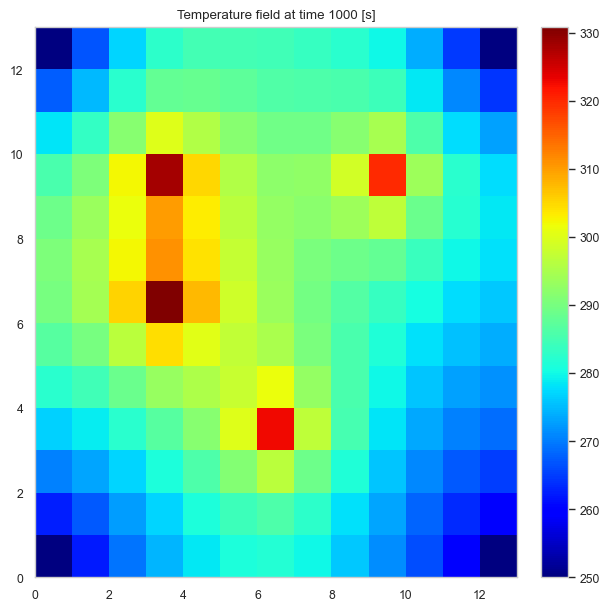

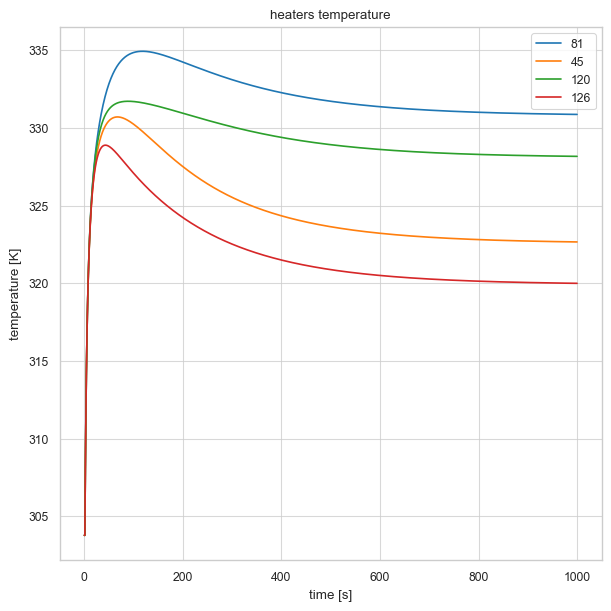

1001

In [7]:
# T1,time1,interfaces1,heaters1 = PCB_case_2(solver='steady',display=True)
T2, time2, interfaces2, heaters2 = PCB_case_2(solver = 'transient', display=True, time = 1000, dt = 1, T_init = 298.0)
T2.shape[0]

# Dataset generation

## Dataset class

In [8]:
sys.path.append('../Convolutional_NN')  # Ajusta la ruta según sea necesario

from Dataset_Class import *

## Dataset Generation

Dataset parameters: variable max and min values, number of data, boundary conditions...

In [9]:
n_train = 500
n_test = 100
nodes_side = 13
time_sim = 1000
dt = 1
T_init = 298.0

n_data = n_train+n_test

input = []
output = []

np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, (n_data, 4))
T_interfaces_random = np.random.uniform(260, 310, (n_data, 4))
T_env_random = np.random.uniform(260, 310, n_data)

Iterating to get the full dataset

In [10]:
time_start = time.time()

for i in range(n_data):
    
    # Print iteration number
    if i%100 == 0:
        print("Generating element number: ",i)
        
    # Generate the data
    T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_random[i], T_interfaces = T_interfaces_random[i], Tenv = T_env_random[i]) # heaters in default position
    # T = T.reshape(T.shape[0], nodes_side,nodes_side) # reshaping the data grid-shape
    
    # Append the data to the list
    output.append(T)
    input1 = []
    # print(T_interfaces_random[i],Q_random[i],T_env_random[i]) # DEBUGGING
    input1 = np.concatenate((T_interfaces_random[i],Q_random[i],[T_env_random[i]]),axis=0)
    # print(input1) # DEBUGGING
    input.append(input1)
    
time_end = time.time()
time_generation_data = time_end-time_start
print("Time to generate the data: ",time_generation_data)

# transform the lists into numpy arrays
input = np.array(input)
output = np.array(output)
output = output.reshape(output.shape[0], output.shape[1], nodes_side,nodes_side) # reshaping the data grid-shape
# print(output.shape) # DEBUGGING

Generating element number:  0
Generating element number:  100
Generating element number:  200
Generating element number:  300
Generating element number:  400
Generating element number:  500
Time to generate the data:  80.68273901939392


Transform dataset into torch tensors

In [11]:
# print(input.shape) # DEBUGGING
input = torch.tensor(input,dtype=torch.float32).to(device)
# print(output.shape) # DEBUGGING
output = torch.tensor(output,dtype=torch.float32).to(device)

T_interfaces = np.zeros((n_data, nodes_side,nodes_side))
Q_heaters = np.zeros((n_data, nodes_side,nodes_side))
T_env = np.zeros((n_data, nodes_side,nodes_side))

for i in range(n_data):
    Q_heaters[i,6,3], Q_heaters[i,3,6],Q_heaters[i,9,3], Q_heaters[i,9,9] = Q_random[i]
    T_interfaces[i,0,0], T_interfaces[i,0,nodes_side-1], T_interfaces[i,nodes_side-1,nodes_side-1], T_interfaces[i,nodes_side-1,0] = T_interfaces_random[i]
    T_env[i,:,:] = T_env_random[i]
    
Q_heaters = torch.tensor(Q_heaters,dtype=torch.float32).to(device)
T_env = torch.tensor(T_env,dtype=torch.float32).to(device)
T_interfaces = torch.tensor(T_interfaces,dtype=torch.float32).to(device)

Calculate averages and standard deviation

In [12]:
# calculate averages and standard deviations
T_interfaces_mean = T_interfaces.mean() # careful because calculated with lots of zeros
T_interfaces_std = T_interfaces.std()
Q_heaters_mean = Q_heaters.mean() # careful because calculated with lots of zeros
Q_heaters_std = Q_heaters.std()
T_env_mean = T_env.mean()
T_env_std = T_env.std()
output_mean = output.mean() 
output_std = output.std()

print(T_interfaces_mean, T_interfaces_std, Q_heaters_mean, Q_heaters_std, T_env_mean, T_env_std, output_mean, output_std) # DEBUGGING
# print(T_interfaces[1, : , :]) # DEBUGGING
# print(torch.count_nonzero(Q_heaters[1, : , :])) # DEBUGGING

tensor(6.7340, device='cuda:0') tensor(43.3060, device='cuda:0') tensor(0.0161, device='cuda:0') tensor(0.1155, device='cuda:0') tensor(284.5063, device='cuda:0') tensor(14.1727, device='cuda:0') tensor(302.9220, device='cuda:0') tensor(12.7937, device='cuda:0')


Saving dataset

In [13]:
# DEBUGGING

print(T_interfaces.shape)
print(Q_heaters.shape)
print(T_env.shape)
print(output.shape)

torch.Size([600, 13, 13])
torch.Size([600, 13, 13])
torch.Size([600, 13, 13])
torch.Size([600, 1001, 13, 13])


In [14]:
dataset_test = PCBDataset(T_interfaces[:n_test,:,:],Q_heaters[:n_test,:,:],T_env[:n_test,:,:],output[:n_test,:,:],
                 T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
                 Q_heaters_std,T_env_mean,T_env_std,output_mean,
                 output_std)

dataset_train = PCBDataset(T_interfaces[n_test:,:,:],Q_heaters[n_test:,:,:],T_env[n_test:,:,:],output[n_test:,:,:],
                 T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
                 Q_heaters_std,T_env_mean,T_env_std,output_mean,
                 output_std)

dataset = PCBDataset(T_interfaces,Q_heaters,T_env,output,
                 T_interfaces_mean,T_interfaces_std,Q_heaters_mean,
                 Q_heaters_std,T_env_mean,T_env_std,output_mean,
                 output_std)


# path directorie for saving datasets
path = os.path.join(dir_path,'Datasets')
if not os.path.exists(path):
    os.makedirs(path)
    
torch.save(dataset, os.path.join(dir_path,"Datasets",'PCB_transient_dataset.pth'))
torch.save(dataset_test, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_test.pth'))
torch.save(dataset_train, os.path.join(dir_path,"Datasets",'PCB_transient_dataset_train.pth'))

# RNN Model

In [15]:
n = 4 # arbitrary
num_layers = 1 # arbitrary
print(input.shape)

input_size = input.shape[1]
output_size = output.shape[2] #*output.shape[3]
hidden_size = input_size*n 
sequence_length = output.shape[1]
input = input.unsqueeze(1).repeat(1, sequence_length, 1) # to use as input for the model
batch_size = input.shape[0]

torch.Size([600, 9])


In [16]:
class PCB_RNN_relu(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PCB_RNN_relu, self).__init__()
        
        # Recurrent layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        
        # Output layer (Fully Connected Layer)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h_0):
        # Recurrent layer forward propagation
        out, h_n = self.rnn(x, h_0)
        
        # Last time step output
        out = self.fc(out)
        
        return out, h_n

In [17]:
class PCB_RNN_tanh(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PCB_RNN_tanh, self).__init__()
        
        # Recurrent layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        
        # Output layer (Fully Connected Layer)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h_0):
        # Recurrent layer forward propagation
        out, h_n = self.rnn(x, h_0)
        
        # whole sequence output
        out = self.fc(out)
        
        return out, h_n

Input data

In [18]:
model_rnn_relu = PCB_RNN_relu(input_size, hidden_size, num_layers, output_size).to(device)

Physics transient loss

In [19]:
class loss_transient_physics(nn.Module):
    def __init__(self, L:float=0.1,thickness:float=0.001,board_k:float=15,ir_emmisivity:float=0.8):
        super(loss_transient_physics, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        nx = ny = nodes_side # square grid
        self.n_nodes = nx*ny
        
        interfaces = [0, nx-1, nx*ny-1, nx*ny-nx]
        
        self.boltzmann_cte = 5.67E-8
        
        # GLs and GRs calculation
        dx = L/(nx-1)
        dy = L/(ny-1)
        GLx = thickness*board_k*dy/dx
        GLy = thickness*board_k*dx/dy
        GR = 2*dx*dy*ir_emmisivity
        
        # Generation of the conductive coupling matrix [K]
        K_cols = []
        K_rows = []
        K_data = []
        for j in range(ny):
            for i in range(nx):
                id = i + nx*j
                if id in interfaces:
                    K_rows.append(id)
                    K_cols.append(id)
                    K_data.append(1)
                else:
                    GLii = 0
                    if i+1 < nx:
                        K_rows.append(id)
                        K_cols.append(id+1)
                        K_data.append(-GLx)
                        GLii += GLx
                    if i-1 >= 0:
                        K_rows.append(id)
                        K_cols.append(id-1)
                        K_data.append(-GLx)
                        GLii += GLx
                    if j+1 < ny:
                        K_rows.append(id)
                        K_cols.append(id+nx)
                        K_data.append(-GLx)
                        GLii += GLy
                    if j-1 >= 0:
                        K_rows.append(id)
                        K_cols.append(id-nx)
                        K_data.append(-GLx)
                        GLii += GLy
                    K_rows.append(id)
                    K_cols.append(id)
                    K_data.append(GLii)
                    
        indices = torch.LongTensor([K_rows, K_cols])
        values = torch.FloatTensor(K_data)
        size = torch.Size([self.n_nodes, self.n_nodes])
        self.K = torch.sparse_coo_tensor(indices, values, size, dtype=torch.float)
        self.K = self.K.to(self.device)
        
        # Generation of the radiative coupling matrix [E]
        E_data = []
        E_id = []
        for id in range(self.n_nodes):
            if id not in interfaces:
                E_id.append(id)
                E_data.append(GR)
                
        indices = torch.LongTensor([E_id, E_id])
        values = torch.FloatTensor(E_data)
        self.E = torch.sparse_coo_tensor(indices, values, size, dtype=torch.float).to(self.device)
        
        
    def forward(self, output, heaters, interfaces, Tenv):
        
        # Q calculation
        heaters = torch.flatten(heaters, start_dim=1)
        interfaces = torch.flatten(interfaces, start_dim=1)
        
        Q = heaters + interfaces
        
        # T generation
        T = torch.flatten(output, start_dim=1)
        
        # Residual calculation
        residual = torch.zeros_like(T)
        
        T, Q, Tenv = T.to(self.device), Q.to(self.device), Tenv.to(self.device)
        
        T = T.transpose(0, 1)
        Q = Q.transpose(0, 1)
        Tenv = Tenv.transpose(0, 1)
        
        residual = torch.sparse.mm(self.K,T) + self.boltzmann_cte*torch.sparse.mm(self.E,(T**4-Tenv**4))-Q # caso estacionario, adaptar a transitorio
        
        return torch.abs(residual)

In [20]:
# x = torch.randn(batch_size, sequence_length, input_size).to(device)
# h_0 = torch.zeros(num_layers, batch_size, hidden_size).to(device)

# # DEBUGGING
# out, h_n = model_rnn_relu(x, h_0)

# print("Dimensión de out:", out.shape)
# print("Dimensión de h_n:", h_n.shape)

## Training

In [21]:
dataset_path = os.path.join(dir_path,'Datasets')

dataset_test:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_test.pth'))
dataset_train:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_train.pth'))
dataset_train.to_device
dataset_test.to_device

n_test = len(dataset_test)
x, y = dataset_train[0]
print(x.shape)  # ¿[F]?
print(y.shape)  # ¿[T, D]?

# # DEBUGGING
# print(x[0]) # T_interfaces (normalizado)
# print(x[1]) # Q_heaters (normalizado)
# print(x[2]) # T_env (normalizado)

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_20552\2716172004.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset_test:PCBDataset = torch.load(os.path.join(dat

torch.Size([3, 13, 13])
torch.Size([1001, 13, 13])


In [22]:
scaler = StandardScaler()

# Convert PyTorch tensor to NumPy array for StandardScaler
input_numpy = input.cpu().numpy()  # Ensure the tensor is on the CPU before converting

data = scaler.fit_transform(input_numpy[:,0,:])

In [23]:
mean = scaler.mean_
deviation = scaler.scale_

print("Mean:", mean) # DEBUGGING
print("Standard deviation:", deviation) # DEBUGGING
data.mean(axis=0), data.std(axis=0) # DEBUGGING
output.shape, input.shape # DEBUGGING
data.mean(), data.std() # DEBUGGING 

Mean: [284.29589391 284.26039734 284.66420039 284.82877106   0.70207178
   0.689717     0.6633004    0.66257099 284.50627833]
Standard deviation: [14.58433133 13.93868002 14.58997202 14.00668023  0.32819676  0.33274823
  0.34184502  0.34232363 14.17259609]


(1.0596382e-09, 1.0)

# Convolutional LSTM

In [24]:
dataset_path = os.path.join(dir_path,'Datasets')

dataset_test:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_test.pth'))
dataset_train:PCBDataset = torch.load(os.path.join(dataset_path,'PCB_transient_dataset_train.pth'))
# dataset_train.to_device
# dataset_test.to_device

n_test = len(dataset_test)
input_train, output_train = dataset_train[:]
sequence_length = output_train.shape[1]
input_train = input_train.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
output_train = output_train.unsqueeze(2)  # 

input_test, output_test = dataset_test[:]
input_test = input_test.unsqueeze(1).repeat(1, sequence_length, 1, 1, 1) # to mantain boundary conditions in all steps
output_test = output_test.unsqueeze(2)  #


input_train = input_train.to(device)
output_train = output_train.to(device)
input_test = input_test.to(device)
output_test = output_test.to(device)

# dataset_train[0][0].shape, dataset_train[0][1].shape # DEBUGGING
# input_train.shape, output_train.shape # DEBUGGING

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_20552\450463698.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset_test:PCBDataset = torch.load(os.path.join(data

In [25]:
from convlstm import *

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=32, kernel_size=(3, 3), height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=[hidden_dim],
                                 kernel_size=kernel_size,
                                 num_layers=1,
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        
        self.decoder = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

Definición del modelo

In [26]:
train_ds = TensorDataset(input_train, output_train)
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

model = PCB_ConvLSTM(input_channels=3, hidden_dim=32, kernel_size=(3, 3), height=13, width=13).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# DEBUGGING
batch = next(iter(train_dl))
x, y = batch

print(f"x está en: {x.device}")
print(f"y está en: {y.device}")

x está en: cuda:0
y está en: cuda:0


Training

In [27]:
epochs = 100
train_loss = []
val_loss = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    for x, y in train_dl:
        
        optimizer.zero_grad()
        y_hat = model(x)
        # print(f"Predicción: {y_hat.shape}, Real: {y.shape}")

        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss.append(total_loss/len(train_dl))
        
    # Validation loss    
    model.eval()
    with torch.no_grad():
        y_pred = model(input_test)
        val_loss.append(criterion(y_pred, output_test))
        print(f"Epoch {epoch+1}, Train Loss: {train_loss[epoch]:.6f}, Validation Loss: {val_loss[epoch]:.6f}")
    
    # print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_dl):.6f}")

Epoch 1, Train Loss: 0.535714, Validation Loss: 0.272665
Epoch 2, Train Loss: 0.238857, Validation Loss: 0.219586
Epoch 3, Train Loss: 0.189127, Validation Loss: 0.174631
Epoch 4, Train Loss: 0.181533, Validation Loss: 0.175159
Epoch 5, Train Loss: 0.171998, Validation Loss: 0.161825
Epoch 6, Train Loss: 0.160617, Validation Loss: 0.158105
Epoch 7, Train Loss: 0.162176, Validation Loss: 0.176811
Epoch 8, Train Loss: 0.157174, Validation Loss: 0.148519
Epoch 9, Train Loss: 0.155105, Validation Loss: 0.148249
Epoch 10, Train Loss: 0.237715, Validation Loss: 0.187812
Epoch 11, Train Loss: 0.171238, Validation Loss: 0.163856


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.02 GiB. GPU 0 has a total capacity of 2.00 GiB of which 0 bytes is free. Of the allocated memory 5.14 GiB is allocated by PyTorch, and 2.06 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Plotting validation loss and train loss

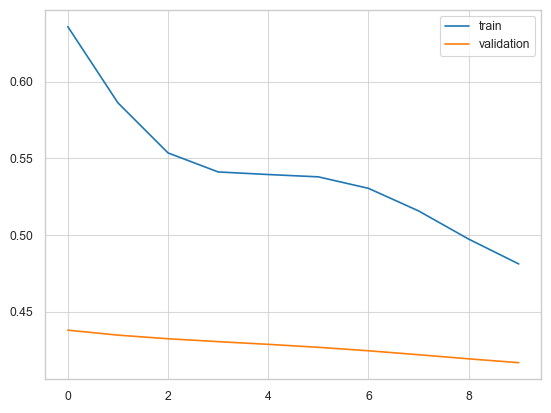

In [ ]:
train_loss_plt = np.array(train_loss)
val_loss_plt = np.array([v.cpu().item() for v in val_loss])

plt.plot(train_loss_plt, label='train')
plt.plot(val_loss_plt, label='validation')
plt.legend()
plt.show()

## Evaluation

In [ ]:
model.eval()

with torch.no_grad():
    y_pred = model(input_test)  # (B, T, 1, H, W)
    test_loss = criterion(y_pred, output_test)
    print(f"Test Loss: {test_loss.item():.6f}")

Test Loss: 0.786629


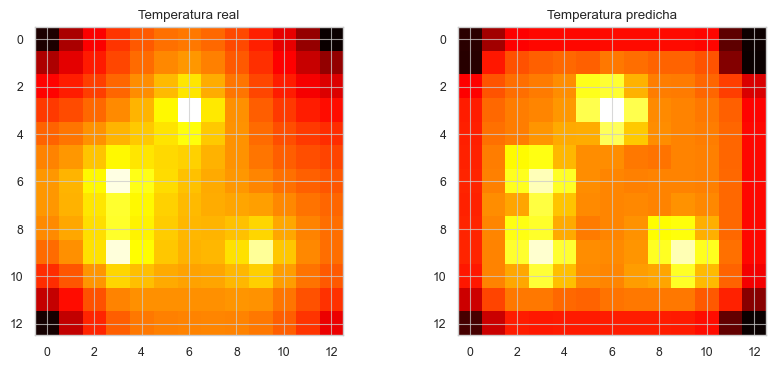

In [ ]:
# Elegimos una muestra y un timestep
i = 0  # muestra
t = 500  # paso temporal

true_map = output_test[i, t].squeeze().cpu().numpy()
pred_map = y_pred[i, t].squeeze().cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(true_map, cmap='hot')
axs[0].set_title("Temperatura real")

axs[1].imshow(pred_map, cmap='hot')
axs[1].set_title("Temperatura predicha")

plt.show()

In [ ]:
def plot_error_map(y_pred, y_true, i=0, t=500):
    """
    Muestra el mapa de temperaturas reales, predichas y el error (por pixel) en un instante concreto.
    Parámetros:
        y_pred: tensor con shape (B, T, 1, H, W)
        y_true: tensor con shape (B, T, 1, H, W)
        i: índice de la muestra
        t: timestep dentro de la secuencia
    """
    real = y_true[i, t].squeeze().detach().cpu().numpy()
    pred = y_pred[i, t].squeeze().detach().cpu().numpy()
    error = pred - real
    abs_error = abs(error)

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    im0 = axs[0].imshow(real, cmap='hot')
    axs[0].set_title("Temperatura real")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(pred, cmap='hot')
    axs[1].set_title("Temperatura predicha")
    plt.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(abs_error, cmap='viridis')
    axs[2].set_title("Error absoluto")
    plt.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

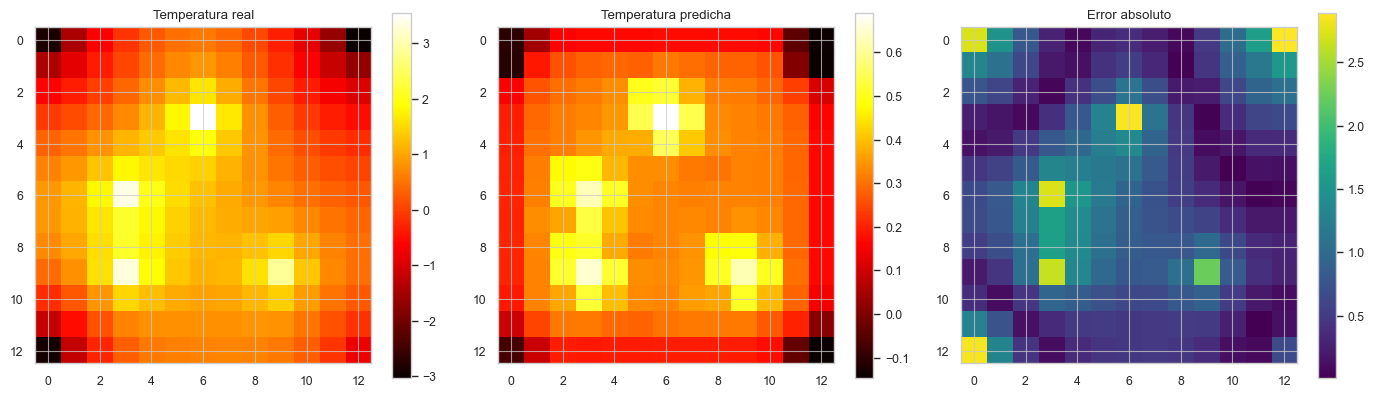

In [ ]:
# Visualizar el error en la muestra 0, paso temporal 500
plot_error_map(y_pred, output_test, i=0, t=500)
